In [1]:
import torch
import sklearn
import sys
import cv2
from tqdm import tqdm_notebook as tqdm
import random
import numpy as np
from torch.utils.data import Dataset, Subset
from torch.utils.data import TensorDataset, DataLoader
import torch.backends.cudnn as cudnn
from torch import nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
from torchvision import datasets, transforms, models
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
# make dataloader
def create_dataloader(dataset_name, transform, valid=False):
    test_dl, valid_dl = None, None

    if dataset_name == 'MNIST':
        train_datasets = datasets.FashionMNIST(root='../datasets', train=True, download=True, transform=transform)
        if valid:
            n_samples = len(train_datasets)
            train_size = int(n_samples * 0.8)
            subset1_indices = list(range(0,train_size))
            subset2_indices = list(range(train_size,n_samples))

            train_dataset = Subset(train_datasets, subset1_indices)
            valid_dataset = Subset(train_datasets, subset2_indices)

            train_dl = DataLoader(train_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True)
            valid_dl = DataLoader(valid_dataset, batch_size=VALID_BATCH_SIZE, shuffle=False)
        else:
            train_dl = DataLoader(train_datasets,   batch_size=TRAIN_BATCH_SIZE, shuffle=True)

        test_dataset = datasets.FashionMNIST(root='../datasets', train=False, download=True, transform=transform)
        test_dl = DataLoader(test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)
    
    return train_dl, test_dl, valid_dl



In [2]:
def im2col(input_data, filter_h, filter_w, stride=1, pad=0):
    N, C, H, W = input_data.shape
    out_h = (H + 2*pad - filter_h)//stride + 1
    out_w = (W + 2*pad - filter_w)//stride + 1

    img = np.pad(input_data, [(0,0), (0,0), (pad, pad), (pad, pad)], 'constant')
    col = np.zeros((N, C, filter_h, filter_w, out_h, out_w))

    for y in range(filter_h):
        y_max = y + stride*out_h
        for x in range(filter_w):
            x_max = x + stride*out_w
            col[:, :, y, x, :, :] = img[:, :, y:y_max:stride, x:x_max:stride]

    col = col.transpose(0, 4, 5, 1, 2, 3).reshape(N*out_h*out_w, -1)
    return col

In [5]:
def myConv2D(data, in_channels, out_channels, kernel_size, padding=0, stride=1, edge=None, num=False, kernel=None):
    in_ch = in_channels
    out_ch = out_channels
    k = kernel_size
    p = padding
    s = stride

    b = 0
    if kernel is None:
        kernel = np.random.randn(out_ch, 1, kernel_size, kernel_size)

    if num:
        N, C, H, W = data.shape
        OH = (H + 2 * p - k)//s + 1
        OW = (W + 2 * p - k)//s + 1
        
        kernel_col = kernel.reshape(out_ch, -1).T
        data_col = im2col(data, k, k, stride=s, pad=p)

        y_col = data_col@kernel_col + b
        
        y = y_col.reshape(N,OH,OW,-1).transpose(0,3,1,2)
    else:
        conv = nn.Conv2d(in_ch, out_ch, k, stride=s, padding=p, bias=False, padding_mode='zeros')
        #nn.init.normal_(conv.weight, 0.0, 0.01)
        conv.weight = nn.Parameter(torch.from_numpy(kernel.astype(np.float32)).clone())

        print(conv.weight.shape)

        y = conv(data)
    
    return y


In [3]:
def one_epoch(model, dl, device, criterion, optimizer=None):
    if optimizer:
        model.train()
    else:
        model.eval()

    losses = 0
    data_num = 0
    correct_num = 0
    iter_num = 0

    for datas, targets in dl:
        datas, targets = datas.to(device), targets.to(device)
        data_num += len(targets)
        iter_num += 1

        if optimizer:
            logits = model(datas)
            loss = criterion(logits, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        else:
            with torch.no_grad():
                logits = model(datas)
                loss = criterion(logits, targets)
            
        losses += loss.item()

        if criterion != nn.MSELoss():
            prediction = torch.argmax(logits,dim=1)
            correct_num += (prediction == targets).sum().item()
    return losses/iter_num, correct_num/data_num
        

In [4]:
def train(model, train_dl, test_dl, epoch, device, criterion, optimizer, early_stop=5, valid_dl=None):

    train_loss_list, valid_loss_list, train_accuracy_list, valid_accuracy_list = [],[],[],[]
    best_train_loss, best_train_acc, best_valid_loss, best_valid_acc = None, None, None, None
    count = 0
    
    for i in range(epoch):
        train_loss, train_acc = one_epoch(model, train_dl, device, criterion, optimizer)
        train_loss_list.append(train_loss)
        train_accuracy_list.append(train_acc)

        if i==0 or best_train_loss >= train_loss:
            best_train_loss = train_loss
            best_train_acc = train_acc
        
        if valid_dl:
            valid_loss, valid_acc = one_epoch(model, valid_dl, device, criterion)
            valid_loss_list.append(valid_loss)
            valid_accuracy_list.append(valid_acc)

            if i%1 == 0:
                print('EPOCH:{:}, Train: loss={:.3}, acc={:.3%} Valid: loss={:.3}, acc={:.3%}'.format(i,train_loss, train_acc, valid_loss, valid_acc))

            if i==0 or best_valid_loss >= valid_loss:
                best_valid_loss = valid_loss
                test_loss, test_acc = one_epoch(model, test_dl, device, criterion)
                count = 0
            else:
                count += 1
                print('early stopping count = {:}'.format(count))
        
            if count >= early_stop:
                print('early stoping : final epoch = {:}'.format(i))
                break   
        else:
            print('EPOCH:{:}, Train: loss={:.3}, acc={:.3%}'.format(i,train_loss, train_acc))

    print('Best train loss={:.3} Test loss={:.3}'.format(best_train_loss, test_loss))
    print('Best train accuracy={:.3} Test accuracy={:.3}'.format(best_train_acc, test_acc))

    return np.array(train_loss_list), np.array(valid_loss_list), np.array(train_accuracy_list), np.array(valid_accuracy_list)

In [6]:
#Q1: 2D convolution
kernel = np.array([[[[1,1,1],[1,1,1],[1,1,1]]]])
input = torch.randn(1, 1, 5, 5)
print(input)

output = myConv2D(input, 1, 1, 3, kernel=kernel)
print(output)

output = myConv2D(input, 1, 1, 3, kernel=kernel, num=True)
print(output)


tensor([[[[-0.1206, -0.3781, -1.8700, -1.2744, -0.4929],
          [ 0.3573,  2.3935, -0.7998, -0.0449, -0.1192],
          [ 0.8589, -0.4934,  0.2577, -0.2995, -0.9087],
          [-1.0291, -0.9700, -1.8067, -1.2224, -0.5392],
          [ 0.5609,  0.8258, -1.5835,  1.0500,  1.1692]]]])
torch.Size([1, 1, 3, 3])
tensor([[[[ 0.2056, -2.5087, -5.5516],
          [-1.2316, -2.9854, -5.4827],
          [-3.3794, -4.2420, -3.8831]]]], grad_fn=<ThnnConv2DBackward>)
[[[[ 0.20558599 -2.50872861 -5.55159898]
   [-1.231621   -2.98542129 -5.48265733]
   [-3.37939203 -4.24198362 -3.88308847]]]]


In [98]:
#Q2: Edge detection
kernel = np.array([[[[-1,-1,-1],[-1,8,-1],[-1,-1,-1]]]])
img = cv2.imread('aicon.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

img = torch.tensor(img).unsqueeze(0).unsqueeze(0).float()
print(img.shape)
output = myConv2D(img, 1, 1, 3, kernel=kernel)
print(output)



torch.Size([1, 1, 256, 256])
torch.Size([1, 1, 3, 3])
tensor([[[[-0.2895, -0.2895, -0.2895,  ..., -0.2895, -0.2895, -0.2895],
          [-0.2895, -0.2895, -0.2895,  ..., -0.2895, -0.2895, -0.2895],
          [-0.2895, -0.2895, -0.2895,  ..., -0.2895, -0.2895, -0.2895],
          ...,
          [-0.2895, -0.2895, -0.2895,  ..., -0.2895, -0.2895, -0.2895],
          [-0.2895, -0.2895, -0.2895,  ..., -0.2895, -0.2895, -0.2895],
          [-0.2895, -0.2895, -0.2895,  ..., -0.2895, -0.2895, -0.2895]]]],
       grad_fn=<MkldnnConvolutionBackward>)


In [99]:
#Q3: Padding
input = torch.randn(1, 1, 5, 5)
print(input)

output = myConv2D(input, 1, 3, 3, padding=1)
print(output)

tensor([[[[ 1.7244,  1.2071,  0.0771,  0.8330, -1.3887],
          [-2.7164,  0.1175,  0.3042, -1.1361,  0.3157],
          [-1.2689,  1.1862,  1.3109, -0.7769, -0.5088],
          [ 1.7412,  0.1888,  1.8008, -0.3305, -1.4820],
          [-0.7751, -1.1304,  0.9362,  1.0618, -1.3783]]]])
torch.Size([3, 1, 3, 3])
tensor([[[[ 0.6989,  3.6332,  0.0873,  3.4001, -0.2132],
          [-6.7449, -1.4980,  0.3839, -0.0800,  2.2106],
          [-4.6272, -6.2700,  3.9083,  0.1236,  1.5452],
          [ 2.6426, -5.9826,  2.2975,  3.5362, -1.6398],
          [ 1.1948, -5.9864, -0.2287,  5.4722, -1.3931]],

         [[ 4.5605, -3.3892, -0.6280,  1.2986, -1.0069],
          [ 4.2871, -0.2687, -1.6787,  1.5682,  1.2900],
          [-2.6994,  2.6545, -5.5968,  0.6984,  4.7225],
          [ 2.4263,  1.9643, -4.3631, -4.2597,  4.2748],
          [ 0.9895,  2.4543,  1.8035, -4.1174, -0.6939]],

         [[-1.2551,  3.6622, -1.3701,  0.5721,  3.8818],
          [ 8.3758,  4.5154, -0.6694, -1.8975,  0.5693],

In [100]:
#Q4: Stride
input = torch.randn(1, 1, 5, 5)
print(input)

output = myConv2D(input, 1, 3, 3, stride=2)
print(output)

tensor([[[[ 1.7406, -1.3600,  0.9502, -0.6952,  0.2370],
          [ 1.4281, -0.5487,  0.7166,  1.8795, -1.1563],
          [-0.5052,  0.3639, -1.1532,  0.5346,  1.0429],
          [-0.7550, -0.0268,  0.1385, -1.4454, -0.1483],
          [-0.9179, -2.2886, -1.1151,  0.9198, -0.4204]]]])
torch.Size([3, 1, 3, 3])
tensor([[[[-0.5839, -2.7763],
          [ 2.5253,  1.6968]],

         [[-0.0492,  0.5053],
          [-0.8724, -2.0257]],

         [[ 9.0587,  2.1591],
          [ 0.3938,  1.7975]]]], grad_fn=<ThnnConv2DBackward>)


EPOCH:0, Train: loss=2.18, acc=19.265% Valid: loss=1.44, acc=42.242%
EPOCH:1, Train: loss=1.13, acc=52.923% Valid: loss=0.744, acc=72.442%
EPOCH:2, Train: loss=0.648, acc=74.775% Valid: loss=0.544, acc=78.275%
EPOCH:3, Train: loss=0.496, acc=81.108% Valid: loss=0.473, acc=81.042%
EPOCH:4, Train: loss=0.414, acc=84.535% Valid: loss=0.398, acc=85.583%
EPOCH:5, Train: loss=0.359, acc=86.704% Valid: loss=0.476, acc=83.767%
early stopping count = 1
EPOCH:6, Train: loss=0.328, acc=87.838% Valid: loss=0.322, acc=88.150%
EPOCH:7, Train: loss=0.301, acc=88.785% Valid: loss=0.303, acc=88.758%
EPOCH:8, Train: loss=0.277, acc=89.700% Valid: loss=0.299, acc=89.300%
EPOCH:9, Train: loss=0.26, acc=90.319% Valid: loss=0.311, acc=88.917%
early stopping count = 1
EPOCH:10, Train: loss=0.249, acc=90.794% Valid: loss=0.298, acc=89.092%
EPOCH:11, Train: loss=0.232, acc=91.269% Valid: loss=0.273, acc=90.042%
EPOCH:12, Train: loss=0.22, acc=91.765% Valid: loss=0.42, acc=85.733%
early stopping count = 1
EPOCH

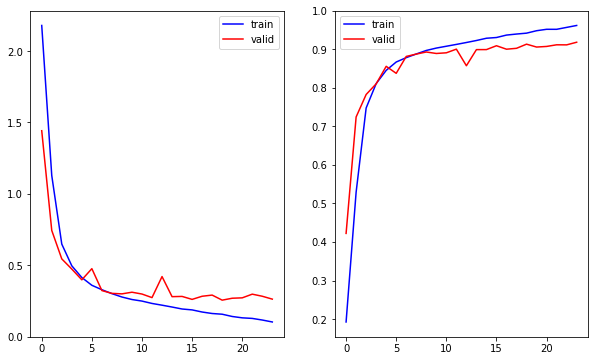

In [5]:
#Q8: VGG
EPOCH_NUM = 100
TRAIN_BATCH_SIZE = 256
VALID_BATCH_SIZE = 256
TEST_BATCH_SIZE = 256
device = f"cuda:{0}" if torch.cuda.is_available() else "cpu"

transform = transforms.Compose(
    [transforms.ToTensor()])

train_dl, test_dl, valid_dl = create_dataloader('MNIST', transform, valid=True)

model = models.vgg11()
model.features[0] = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model.features[11] = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
model.features[13] = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
for i in range(16,21):
    model.features[i] = nn.Sequential()
model.classifier[0] = nn.Linear(in_features=12544, out_features=4096, bias=True) 
model.classifier[6] = nn.Linear(in_features=4096, out_features=10, bias=True)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

train_loss_list, test_loss_list, train_accuracy_list, test_accuracy_list = train(model, train_dl, test_dl, EPOCH_NUM, device, criterion, optimizer, valid_dl=valid_dl)

fig= plt.figure(figsize=(10.0, 6.0))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(train_loss_list, 'b', label='train')
ax1.plot(test_loss_list, 'r', label='valid')
ax1.legend()

ax2 = fig.add_subplot(1,2,2)
ax2.plot(train_accuracy_list, 'b', label='train')
ax2.plot(test_accuracy_list, 'r', label='valid')
ax2.legend()
plt.show()

